In [1]:
import glob  # return file paths with specific file format or pattern
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream  # package to read and execute midi files
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD # Momentum cell to be added in the model
# Libraries for Visualization
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [14]:
notes = [] # Dataframe to store the notes for the Midi files
for file in glob.glob("F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input/*.midi"):
    # Generate music21 objects
    Music21Obj = converter.parse(file)
    print("Parsing %s" % file)
    notes_to_parse = None
    try:
        #  subclassing, though instrument
        subclass = instrument.partitionByInstrument(Music21Obj)
        notes_to_parse = subclass.parts[0].recurse() 
    except: 
        notes_to_parse = Music21Obj.flat.notes
    # Extract Pitch / Chord info 
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

Parsing F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.midi
Parsing F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.midi
Parsing F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--3.midi
Parsing F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--4.midi
Parsing F:/National College of Ireland/Research in Computing/Music/Maestro Dataset/maestro-v1.0.0/input\MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--1.midi
Parsing F:/National College of Ireland/Research in Computing/Music/Maestro 

In [15]:
with open('F:/National College of Ireland/Research Project/MLSTM/data/notes', 'wb') as filepath:
    pickle.dump(notes, filepath)


In [16]:
n_vocab = len(set(notes))
sequence_length = 100
# Pitch info
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

Train_X = []
Train_y = []

In [17]:
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    Train_X.append([note_to_int[char] for char in sequence_in])
    Train_y.append(note_to_int[sequence_out])

n_patterns = len(Train_X)

Train_X = numpy.reshape(Train_X, (n_patterns, sequence_length, 1))
Train_X = Train_X / float(n_vocab)

Train_y = np_utils.to_categorical(Train_y)

In [18]:
# LSTM Model
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(Train_X.shape[1], Train_X.shape[2]),
    recurrent_dropout=0.3,
    return_sequences=True
))

In [19]:
# Recurrent layer
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)              

In [21]:
# Training
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

model.fit(Train_X, Train_y, epochs=30, batch_size=1000, callbacks=callbacks_list)
scores = model.evaluate(Train_X, Train_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/30
56/56 [==============================] - 2129s 38s/step - loss: 0.6807 - accuracy: 0.0019
Epoch 2/30
56/56 [==============================] - 2466s 44s/step - loss: 0.6453 - accuracy: 0.0016
Epoch 3/30
56/56 [==============================] - 2024s 36s/step - loss: 0.5933 - accuracy: 0.0020
Epoch 4/30
56/56 [==============================] - 2399s 43s/step - loss: 0.5101 - accuracy: 0.0019
Epoch 5/30
56/56 [==============================] - 2021s 36s/step - loss: 0.4004 - accuracy: 0.0025
Epoch 6/30
56/56 [==============================] - 2148s 38s/step - loss: 0.2904 - accuracy: 0.0029
Epoch 7/30
56/56 [==============================] - 1985s 35s/step - loss: 0.2055 - accuracy: 0.0032
Epoch 8/30
56/56 [==============================] - 1987s 36s/step - loss: 0.1492 - accuracy: 0.0034
Epoch 9/30
56/56 [==============================] - 1880s 33s/step - loss: 0.1135 - accuracy: 0.0038
Epoch 10/30
56/56 [==============================] - 1930s 35s/step - loss: 0.0904 - accura

In [26]:
def prepare_sequences(notes, pitchnames, n_vocab):
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    Test_X = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        Test_X.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(Test_X)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(Test_X, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (Test_X, normalized_input)

In [34]:
def create_network(Test_X, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(Test_X.shape[1], Test_X.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    epochs = 50
    learning_rate = 0.1
    decay_rate = learning_rate / epochs
    momentum = 0.8
    sgd = SGD(learning_rate==learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    model.load_weights('C:/Users/SACHIN/weights-improvement-30-0.0254-bigger.hdf5')
 
    return model

In [30]:
def generate_notes(model, Test_X, pitchnames, n_vocab):
    start = numpy.random.randint(0, len(Test_X)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = Test_X[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [31]:
def create_midi(prediction_output):
    offset = 0
    output_notes = []
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')
with open('F:/National College of Ireland/Research Project/MLSTM/data/notes', 'rb') as filepath:
    music21_obj = pickle.load(filepath)

pitchnames = sorted(set(item for item in music21_obj))
n_vocab = len(set(music21_obj))
Test_X, normalized_input = prepare_sequences(music21_obj, pitchnames, n_vocab)
model = create_network(normalized_input, n_vocab)
prediction_output = generate_notes(model, Test_X, pitchnames, n_vocab)
create_midi(prediction_output)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 512)          2099200   
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activation)    (None, 256)              

In [43]:

FILENAME="F:/National College of Ireland/Research Project/MLSTM/output.mid" 

# Listing current data on our folder.

print(os.listdir("."))


from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(FILENAME, True)
#print(base_midi)

['.3T', '.conda', '.condarc', '.continuum', '.docker', '.dotnet', '.gitconfig', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.mongorc.js', '.RapidMiner', '.spss', '.spyder-py3', '.ssh', '.VirtualBox', '3D Objects', 'anaconda3', 'AppData', 'Apple', 'Apple and Mango problem (MSO).ipynb', 'Application Data', 'Assesment Numpy.ipynb', 'bluej', 'CA.ipynb', 'CA1x19198159.ipynb', 'conda', 'Contacts', 'Cookies', 'Creative Cloud Files', 'DAP Lab 3 .ipynb', 'DAP Lab2.ipynb', 'DAP Lab3 q5.ipynb', 'DAP.ipynb', 'debug.log', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'FINAL CA1(People) Annu.ipynb', 'Final CA1(People) Parrys.ipynb', 'IntelGraphicsProfiles', 'Lab 2..ipynb', 'Lab4DAP.ipynb', 'LinearReg1.ipynb', 'LinearReg2.ipynb', 'LinearReg3.ipynb', 'Links', 'Local Settings', 'MAIN_Momentum_LSTM.py', 'Microsoft', 'MicrosoftEdgeBackups', 'MIDIs', 'ML Practice1.ipynb', 'ML Practice2.ipynb', 'mlstm.ipynb', 'Momentum LSTM.ipynb', 'Music', 'My Documents', 'NetHoo

In [44]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

print(list_instruments(base_midi))

List of instruments found on MIDI file:
FL Keys
None


In [45]:

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

In [46]:
def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()


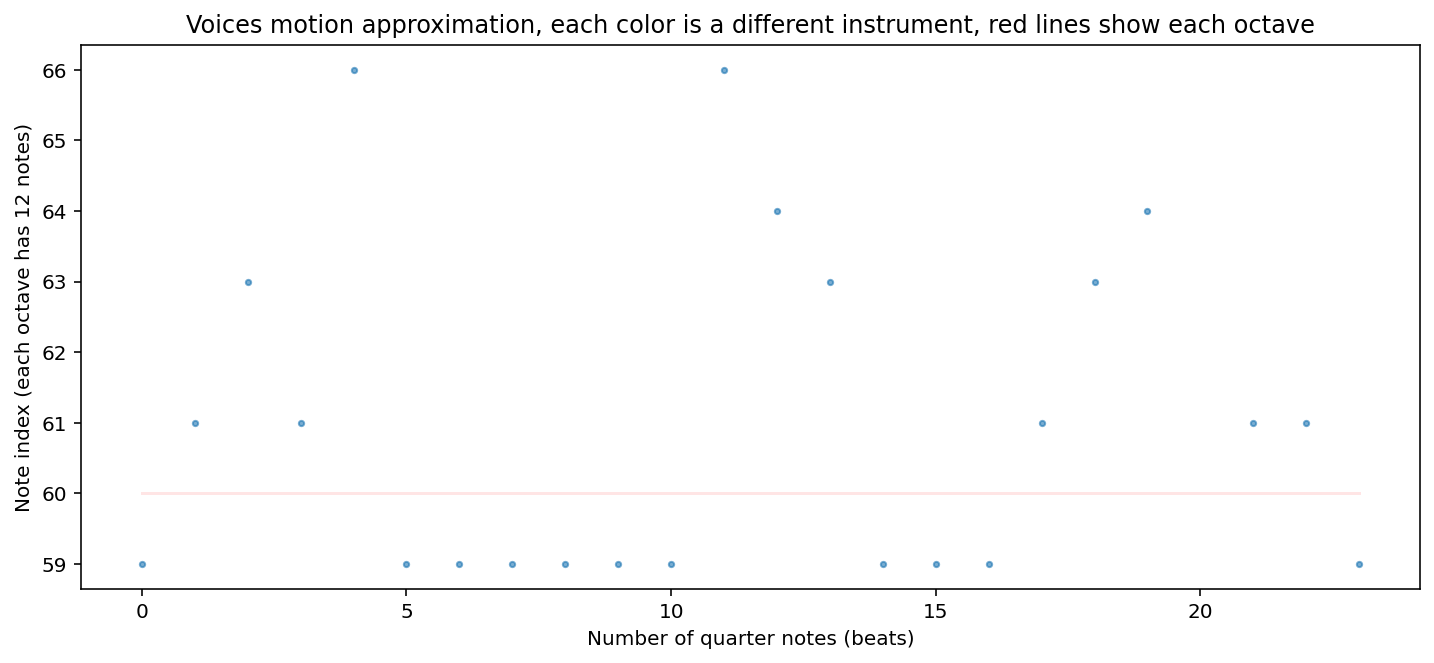

Music time signature: 4/4
Expected music key: B major
Music key confidence: 0.6467421040449469
Other music key alternatives:
g# minor
b minor


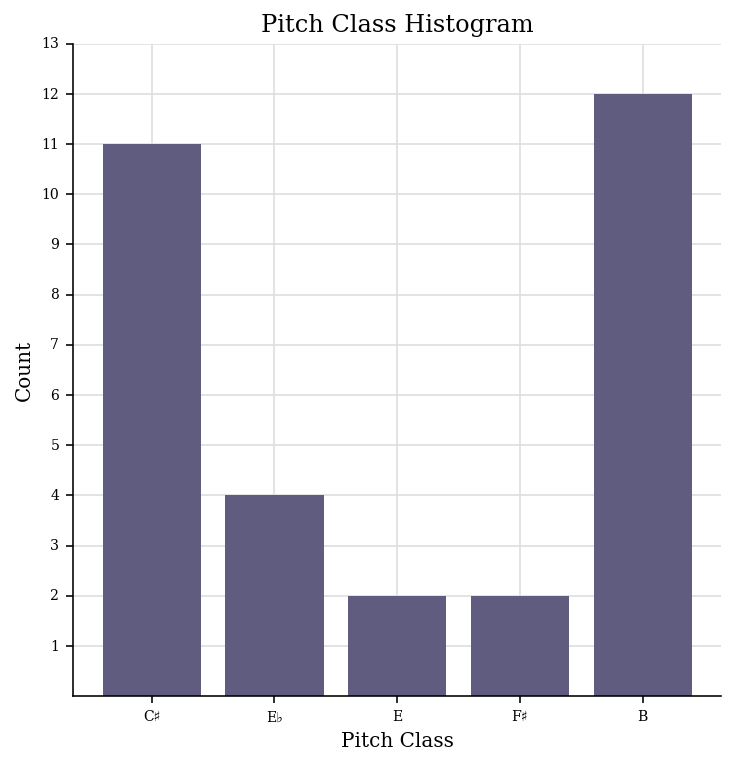

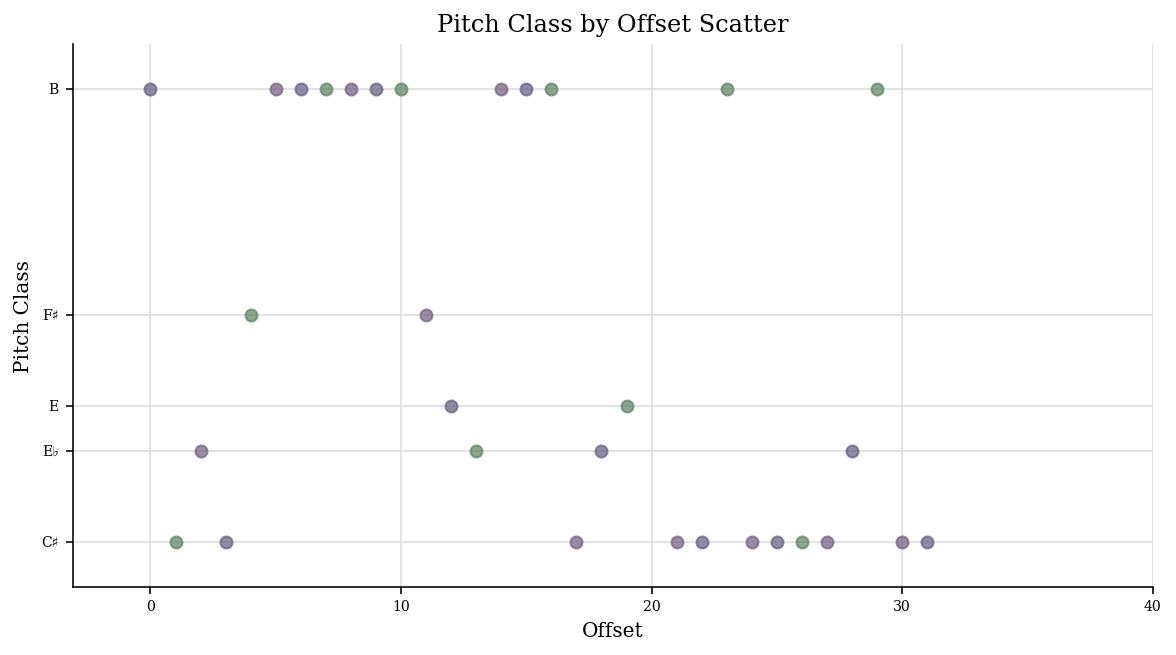

In [47]:
# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

base_midi.plot('histogram', 'pitchClass', 'count')
base_midi.plot('scatter', 'offset', 'pitchClass')

timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)


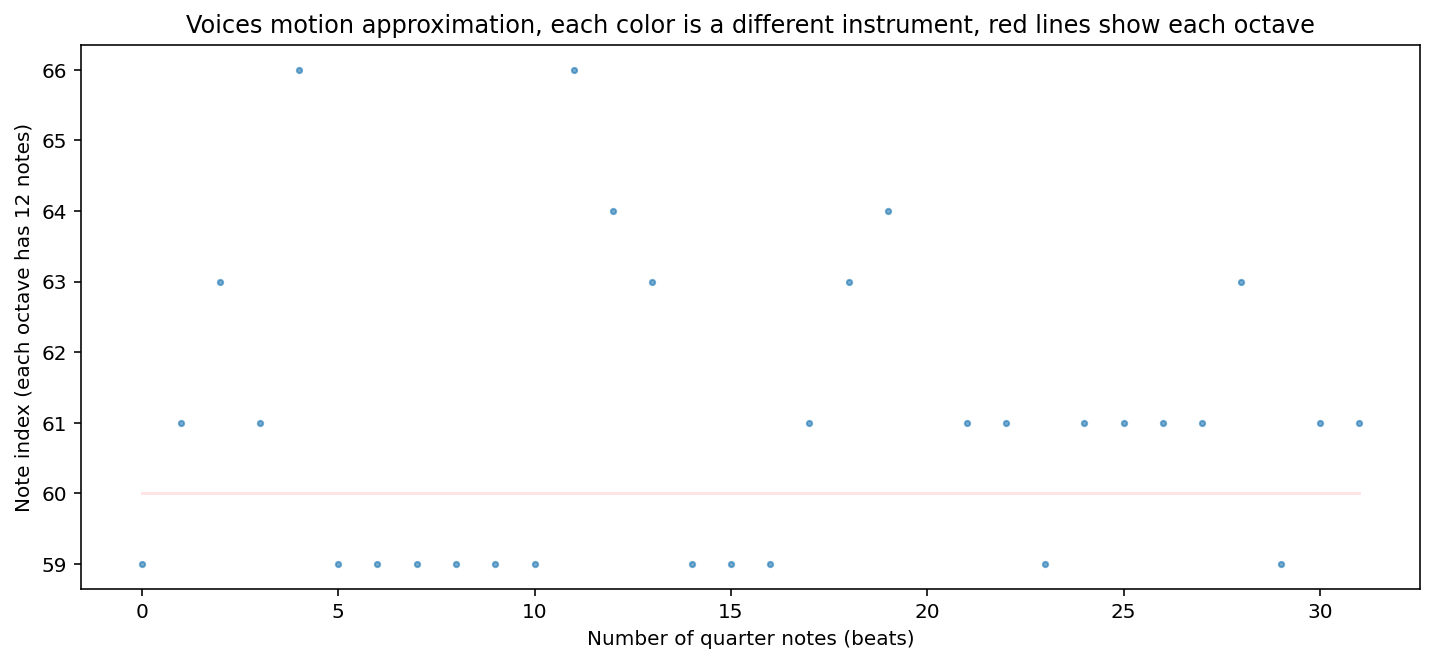

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Flute 'FL Keys: FL Keys'>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=116.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord B3>
    {1.0} <music21.chord.Chord C#4>
    {2.0} <music21.chord.Chord E-4>
    {3.0} <music21.chord.Chord C#4>


In [48]:

temp_midi_chords = open_midi(FILENAME,True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")
